## Import Data ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn
import librosa
import librosa.display
import pandas as pd
import numpy as np
from scipy.stats import *
import random
import time
from skimage.transform import resize
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
audio_path = []
labels = []

dir_path = os.getcwd()

for i in os.listdir(f"{dir_path}/data"):
    for label in os.listdir(f"{dir_path}/data/{i}"):
        for audio in os.listdir(f"{dir_path}/data/{i}"):
            audio_path.append(f"{dir_path}/data/{i}/{audio}")
            labels.append(i)

df = pd.DataFrame(zip(audio_path, labels), columns = ["audio_path", "Labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,audio_path,Labels
0,/Users/jay/Jupyter Projects/GenderRecognition/...,male
1,/Users/jay/Jupyter Projects/GenderRecognition/...,male
2,/Users/jay/Jupyter Projects/GenderRecognition/...,male
3,/Users/jay/Jupyter Projects/GenderRecognition/...,male
4,/Users/jay/Jupyter Projects/GenderRecognition/...,male
...,...,...
16143,/Users/jay/Jupyter Projects/GenderRecognition/...,female
16144,/Users/jay/Jupyter Projects/GenderRecognition/...,female
16145,/Users/jay/Jupyter Projects/GenderRecognition/...,female
16146,/Users/jay/Jupyter Projects/GenderRecognition/...,female


## Statistical Modeling ##

Shape:  (16148, 2)

Counts:
 Labels
male      10380
female     5768
Name: count, dtype: int64



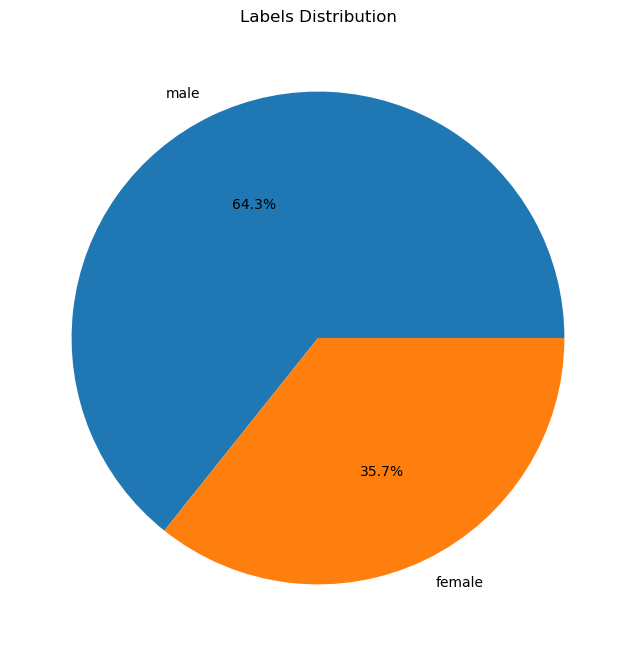

In [4]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["Labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["Labels"].value_counts(), labels = df["Labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

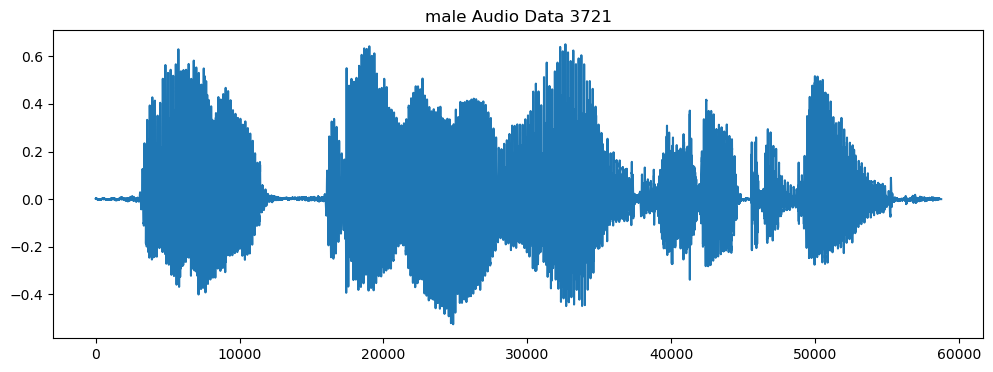

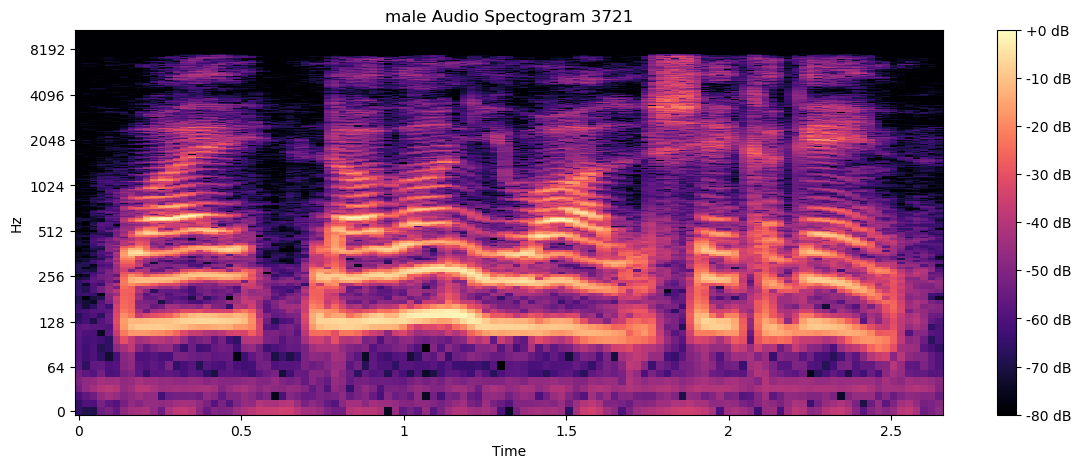

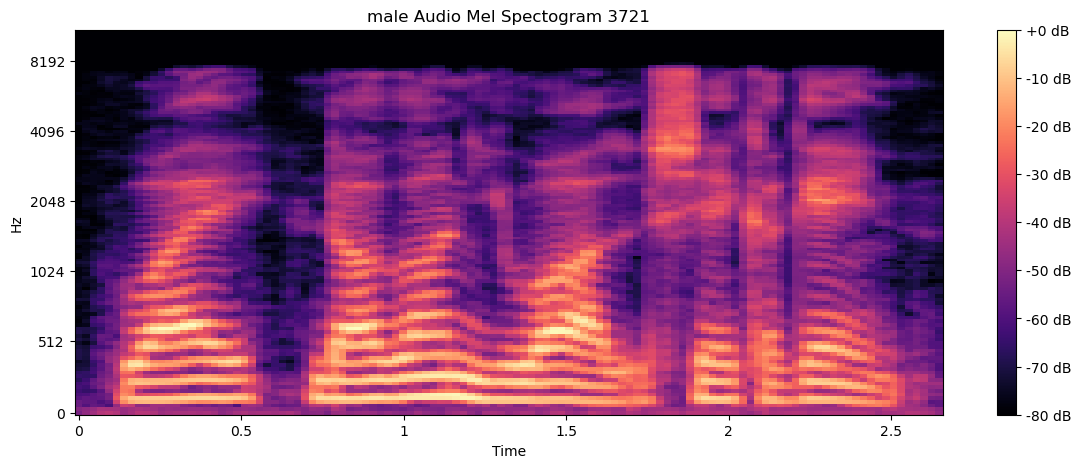

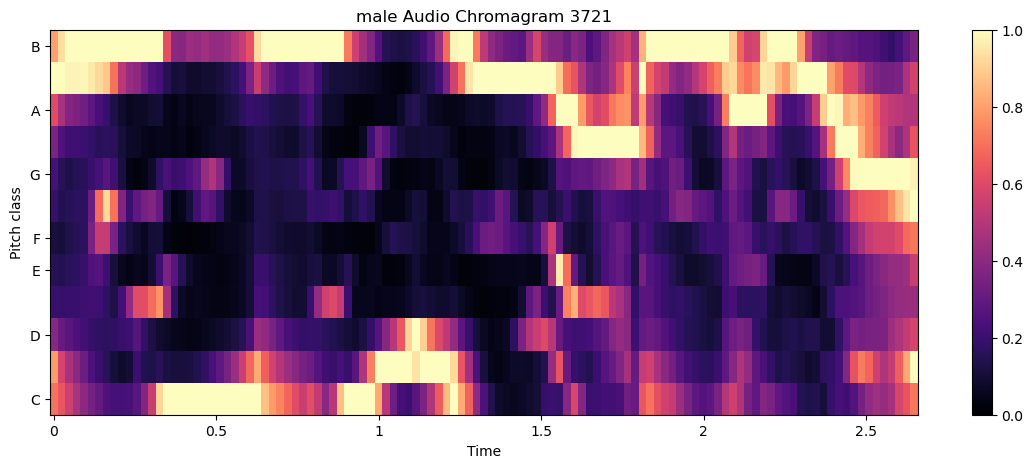

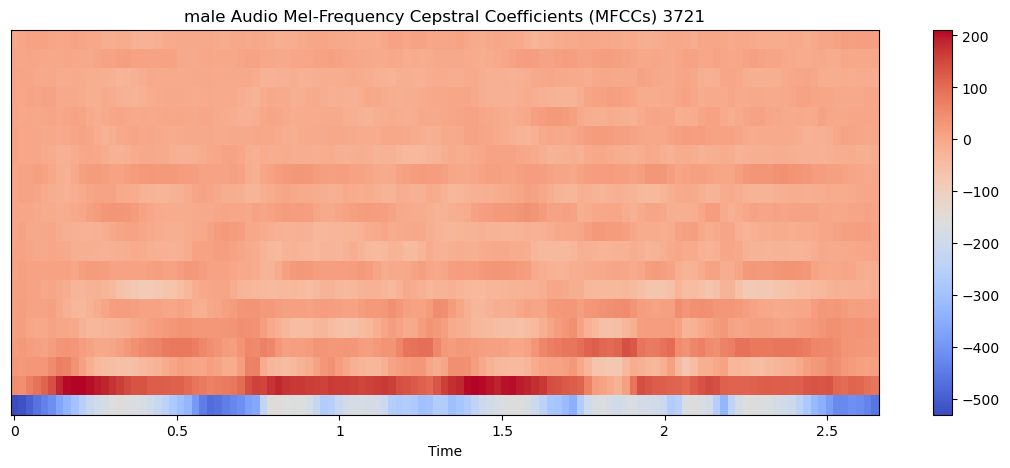

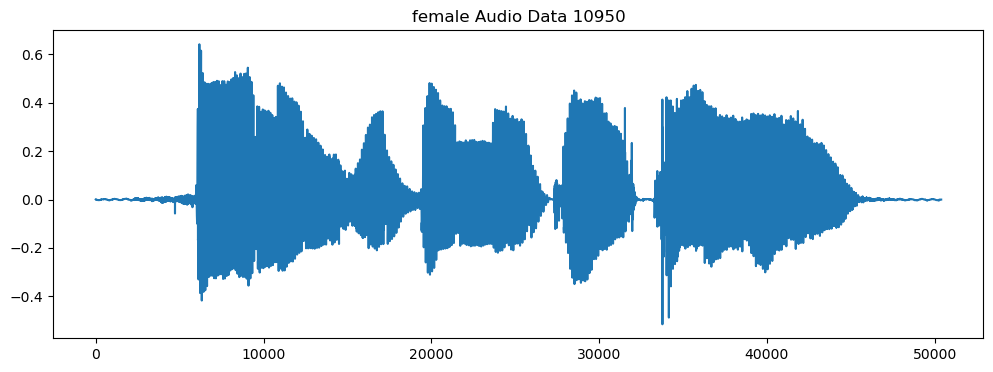

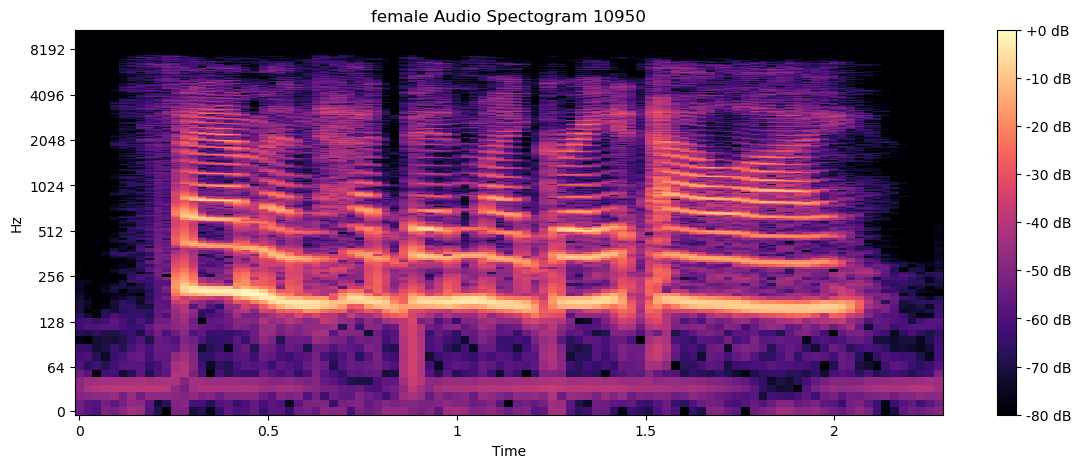

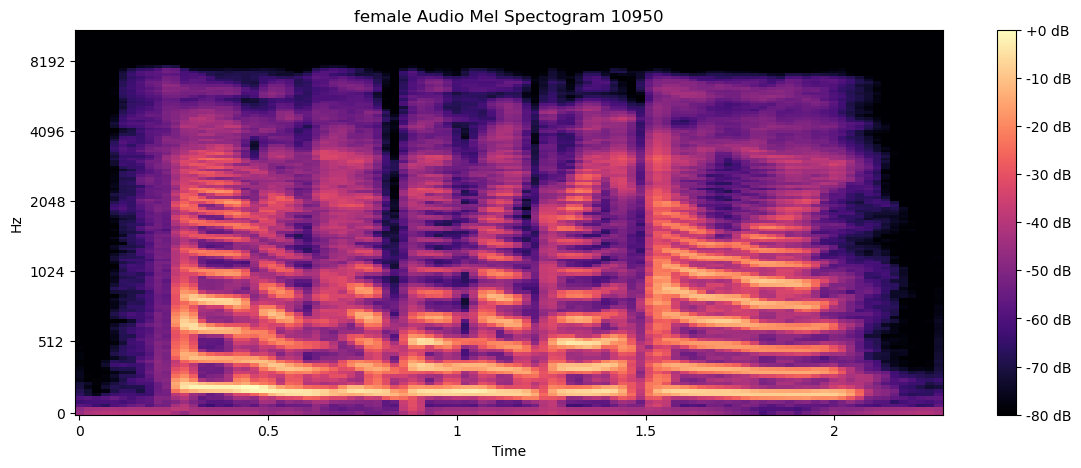

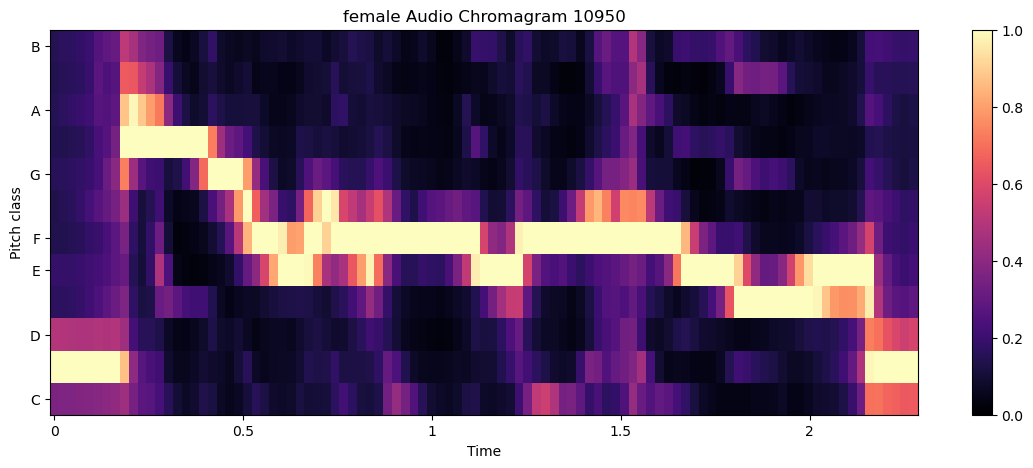

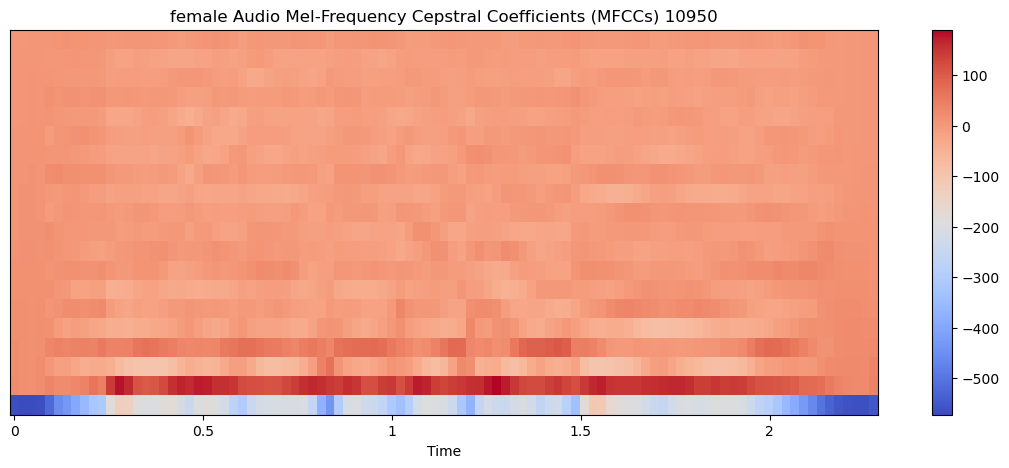

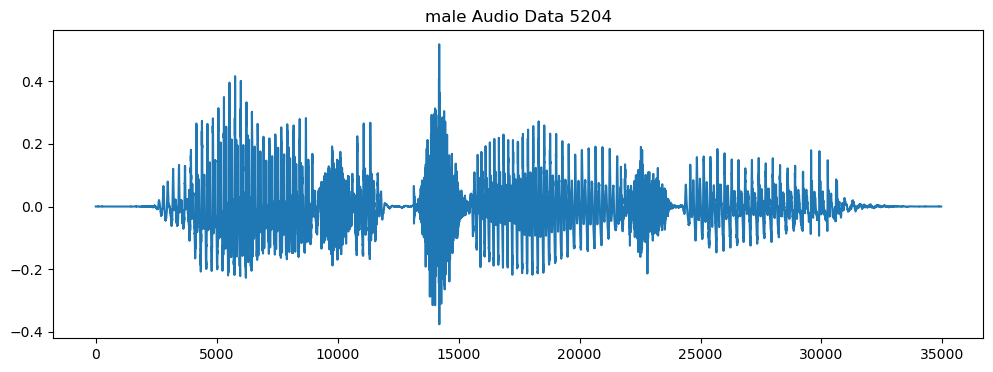

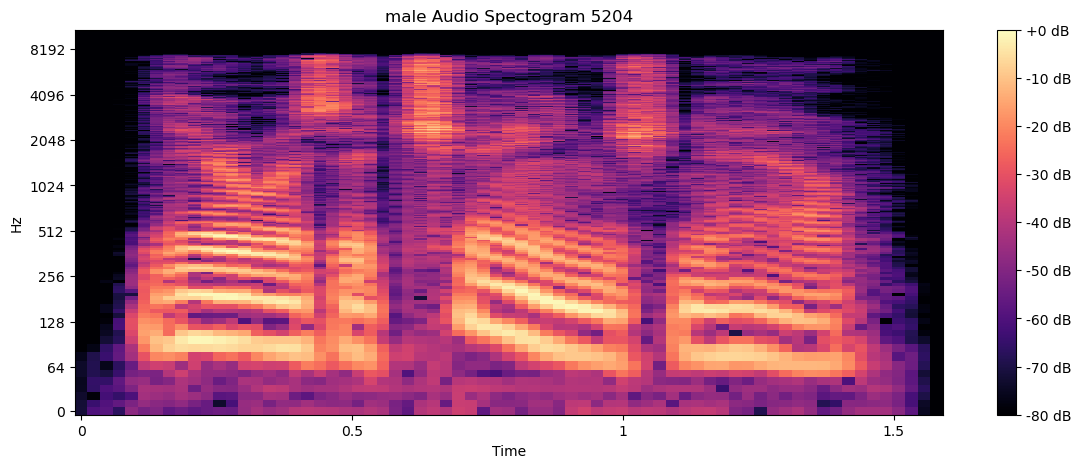

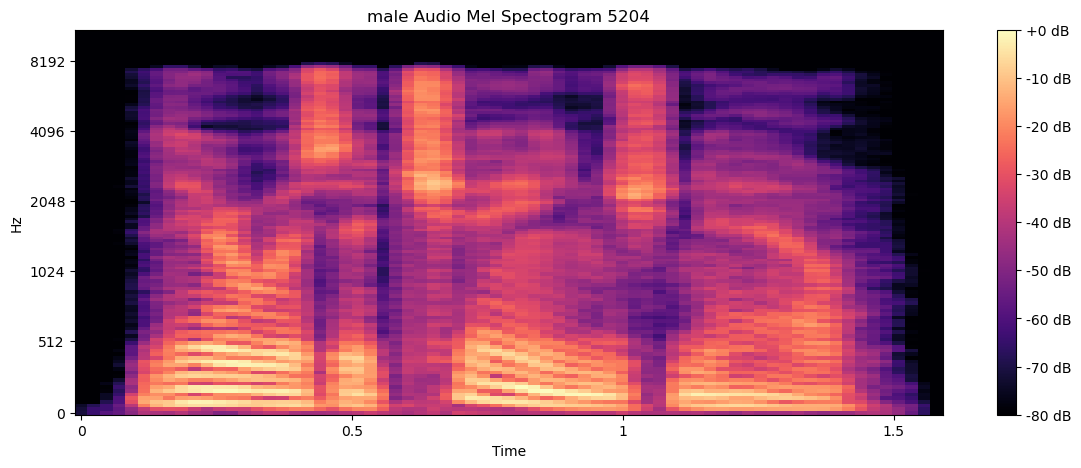

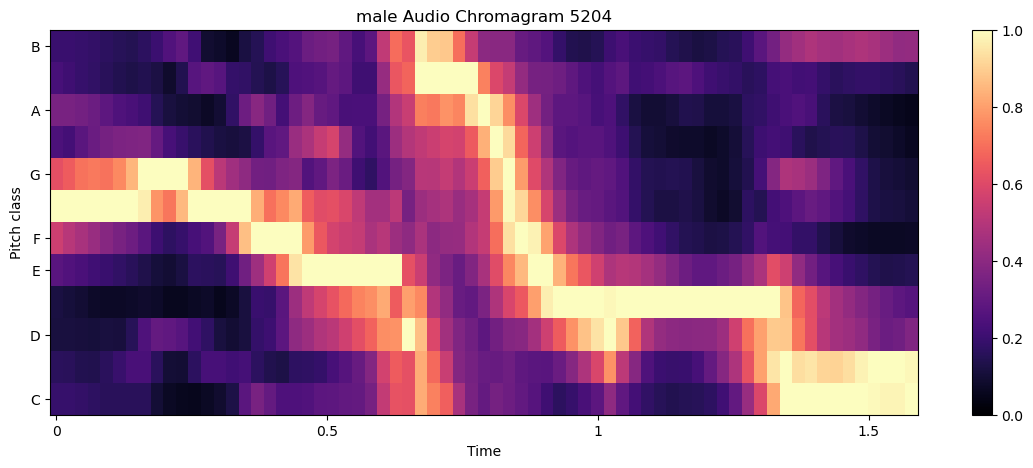

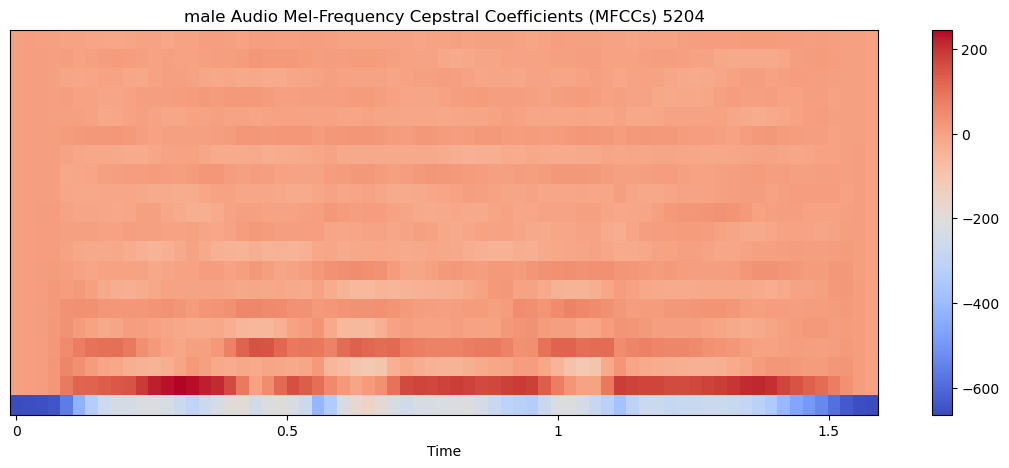

In [5]:
for i in range(3):
    x = random.randint(0, len(df))
    
    real_ad, real_sr = librosa.load(df.iloc[x,0])
    plt.figure(figsize=(12, 4))
    plt.plot(real_ad)
    plt.title(f"{df.iloc[x,1]} Audio Data {x}")
    plt.show()
    
    real_spec = np.abs(librosa.stft(real_ad))
    real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"{df.iloc[x,1]} Audio Spectogram {x}")
    plt.show()
    
    real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
    real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
    plt.title(f"{df.iloc[x,1]} Audio Mel Spectogram {x}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()
    
    real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"{df.iloc[x,1]} Audio Chromagram {x}")
    plt.show()
    
    real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
    plt.colorbar()
    plt.title(f"{df.iloc[x,1]} Audio Mel-Frequency Cepstral Coefficients (MFCCs) {x}")
    plt.show()

## Training Model ##

In [6]:
le = LabelEncoder()
df["Labels"] = le.fit_transform(df["Labels"])

train = df.sample(frac = 0.7, random_state = 7)
test = df.drop(train.index)

val = test.sample(frac = 0.5, random_state = 7)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11304, 2)
(2422, 2)
(2422, 2)


In [7]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe["Labels"])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe["audio_path"]]
        
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label

    def get_spectrogram(self, file_path):
        sr = 44000
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr = sr, duration = duration)
        spec = librosa.feature.melspectrogram(y = signal, sr = sr, n_fft=2048, hop_length = 512, n_mels = 128)
        spec_db = librosa.power_to_db(spec, ref = np.max)

        spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr) // 512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [8]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

In [9]:
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 10

In [10]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64*16*32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)

        self.output = nn.Linear(512, len(df["Labels"].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        
        x = self.conv2(x)
        x = self.pooling(x)
        
        x = self.conv3(x)
        x = self.pooling(x)
        
        x = self.relu(x)

        x = x.view(x.size(0), -1)

        x = self.flatten(x)
        
        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

In [12]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [13]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            134,221,824
├─Linear: 1-8                            4,195,328
├─Linear: 1-9                            524,800
├─Linear: 1-10                           1,026
├─Dropout: 1-11                          --
Total params: 138,966,274
Trainable params: 138,966,274
Non-trainable params: 0

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [15]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/100, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/100, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/10 
    Training Loss: 5.6577 
    Training Accuracy: 96.0191 
    Validation Loss: 0.0491 
    Validation Accuracy: 99.422
Epoch no. 2/10 
    Training Loss: 0.3775 
    Training Accuracy: 99.1154 
    Validation Loss: 0.0385 
    Validation Accuracy: 99.5458
Epoch no. 3/10 
    Training Loss: 0.2642 
    Training Accuracy: 99.4161 
    Validation Loss: 0.0826 
    Validation Accuracy: 99.2981
Epoch no. 4/10 
    Training Loss: 0.222 
    Training Accuracy: 99.4958 
    Validation Loss: 0.0497 
    Validation Accuracy: 99.5045
Epoch no. 5/10 
    Training Loss: 0.1885 
    Training Accuracy: 99.5488 
    Validation Loss: 0.0253 
    Validation Accuracy: 99.7936
Epoch no. 6/10 
    Training Loss: 0.2973 
    Training Accuracy: 99.4781 
    Validation Loss: 0.0606 
    Validation Accuracy: 99.4633
Epoch no. 7/10 
    Training Loss: 0.119 
    Training Accuracy: 99.7788 
    Validation Loss: 0.0536 
    Validation Accuracy: 99.8348
Epoch no. 8/10 
    Training Loss: 0.3335 
 

In [16]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 99.6697 
Loss: 0.0


## Post-Training Analysis ##

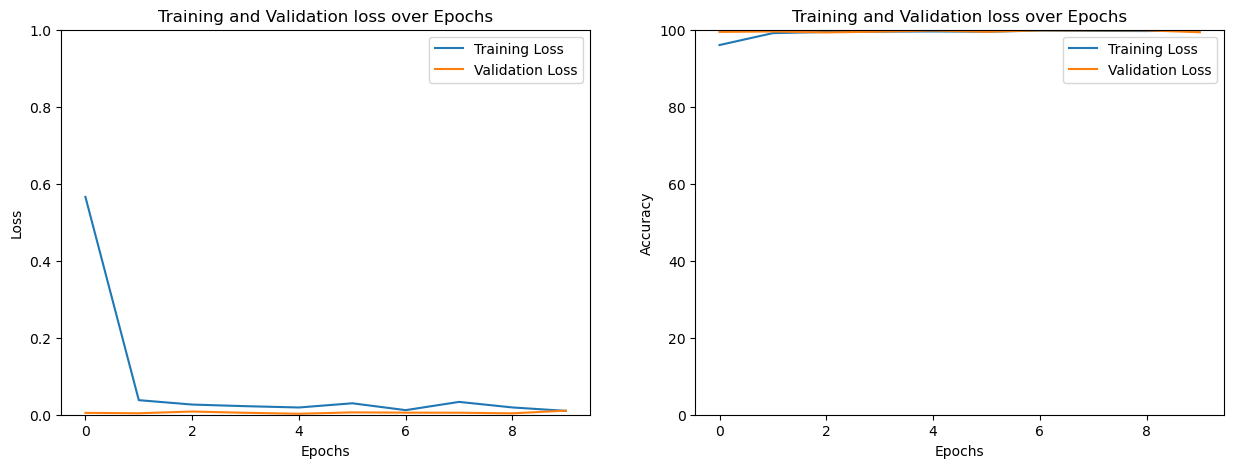

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [18]:
torch.save(model.state_dict(), "GenderRecognition.pth")

In [19]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("GenderRecognition.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

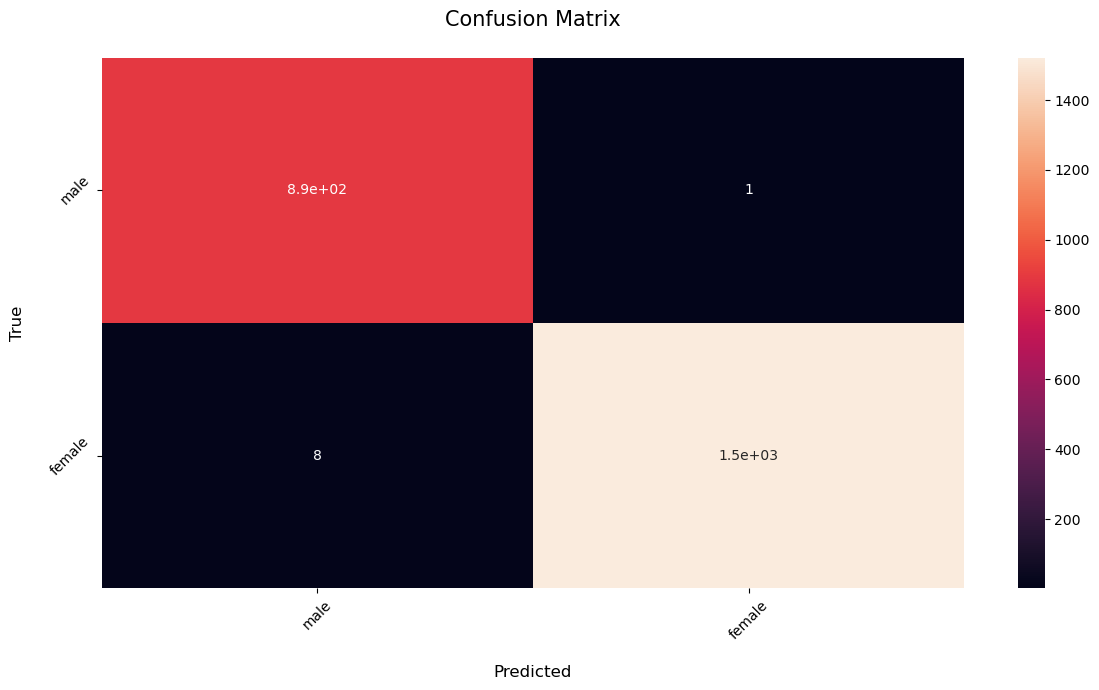

In [20]:
y_pred = []
y_true = []

loaded_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.max(outputs, 1)[1]

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

classes = le.inverse_transform(df["Labels"].unique().tolist())

cf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix\n", fontsize=15)
plt.xlabel("\nPredicted", fontsize=12)
plt.ylabel("True\n", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
def get_spectrogram_for_display(file_path):
    sr = 44000
    duration = 5
    img_height = 128
    img_width = 256

    signal, sr = librosa.load(file_path, sr=sr, duration=duration)
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=img_height)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    spec_resized = librosa.util.fix_length(spec_db, size=(duration * sr) // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    
    return spec_resized

In [22]:
def predict_audio(file_path, return_probs=False):
    loaded_model.eval()
    
    spec = get_spectrogram_for_display(file_path)
    audio_tensor = torch.tensor(spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = loaded_model(audio_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    
    if return_probs:
        return probs.squeeze().cpu().numpy()
    
    return le.inverse_transform([predicted_class])[0]

In [23]:
def prediction(x, paths, label_names=None):
    fig, axes = plt.subplots(1, x, figsize=(10*x, 8))

    if x == 1:
        axes = [axes]

    for i in range(x):
        path = paths[i]
        spec = get_spectrogram_for_display(path)
        
        pred_class = predict_audio(path)
        probs = predict_audio(path, return_probs=True)
    
        pred_index = le.transform([pred_class])[0]
    
        ax = axes[i]
        img = librosa.display.specshow(
            spec, sr=44000, hop_length=512,
            x_axis="time", y_axis="mel", ax=ax, cmap="magma"
        )
        
        title_text = f"Predicted Class: {pred_class}\n"
        title_text += f"Class Probability: {probs[pred_index]:.2f}"
        
        ax.set_title(title_text, fontsize=14)
        ax.axis("off")

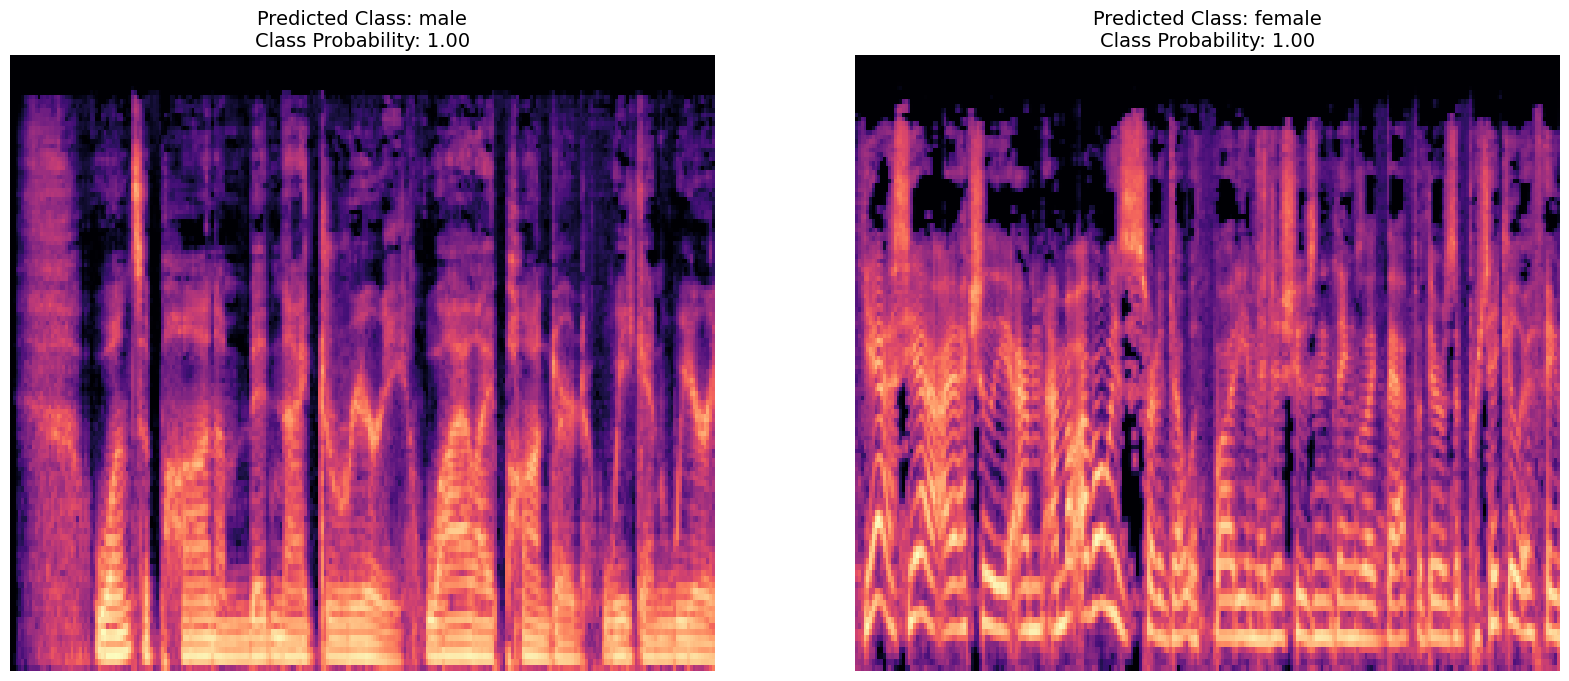

In [26]:
paths = [
    f"{dir_path}/Man.mp3",
    f"{dir_path}/Woman.mp3"
]

label_names = df["Labels"].unique().tolist()

prediction(len(paths), paths, label_names=label_names)

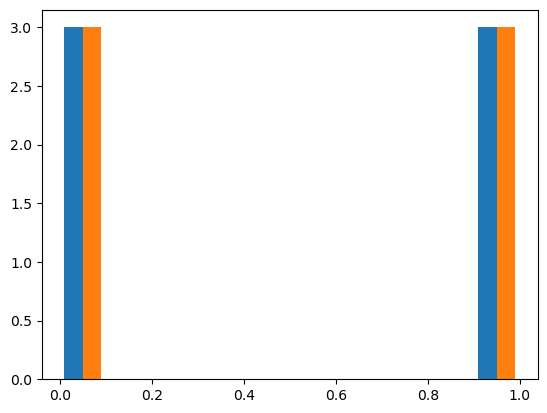

In [27]:
probs = F.sigmoid(outputs)
plt.hist(np.array(probs.cpu()))
plt.show()